In [2]:
%matplotlib inline
from importlib import reload
import numpy as np
import pathlib
import matplotlib.pyplot as plt

from ics.cobraCharmer import pfiDesign
from ics.cobraCharmer import cobraState

from ics.cobraCharmer.utils import butler
from procedures.moduleTest import moduleTest, calculation, ontimeModel, plotUtils


2019-09-13 03:53:02.632Z matplotlib.pyplot 10 pyplot.py:225 Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## 1 - Bootstrap

Takes the initial XML map from the assembly bench and makes it functional
 - does a frequency calibratikon on both motors (separately).
 - assigns starting center positions from the found fiber spots.
 - initializes some parts of the geometry, clears the rest.
 
Note that bootstrapping *requires* that the the cobras be in the theta-out, phi-in safe positions. Due to the
frequency calibration the theta positions will need to be manually restored after bootstrapping. 

The input map, for the example module named "SC42", "SC42_init.xml", and comes from the assembly bench procedures. The output map is "SC42_bootstrap.xml". This is then used for the next step.

In [3]:
moduleName = "SC42"

In [ ]:
from procedures.cit import bootstrapModule

# CPL: Get the ordering from the "site" module.
bootstrapMap = bootstrapModule.bootstrapModule(moduleName, numberCobrasFromRight=True)

## 2 - Please manually reset theta motors

Sorry, but the frequency calibration almost certainly moved the theta motors. Please manually put them back to the "out" position.


## 3 - Make phi motor maps at several ontimes; create working phi map

Takes a set of phi motor maps at a range of ontimes, then generates a new map with tuned slow and fast maps.

Since we are only looking for overall ontimes, we make coarse (200-step) runs.

The initial map is named "SC42_bootstrap.xml", and the final output is "SC42_phiOntime.xml".

In [ ]:
mt = moduleTest.ModuleTest('fpga', butler.mapPathForModule(moduleName, version='bootstrap'))

phiRuns = dict()
for phiOntime in 50,35,20:
    outputDir = mt.makePhiMotorMap(f'phi_{phiOntime}ms.xml', phiOnTime=phiOntime/1000, 
                                   updateGeometry=True, repeat=1, fast=False, steps=100)
    phiRuns[phiOntime] = outputDir

## 4 - Build "optimal" phi map

Using the phi ontime scans we just made, solve for the per-motor ontimes we want to use

CPL -- This is _far_ from  optimal. 

In [ ]:
poptmap = ontimeMap.ontimeModel.loadFromPhiData(phiRuns.values())
poptmap.solveForSlowSpeed()
poptmap.solveForFastSpeed()
bestFW, bestRV = optmap.saveOptMap(butler.mapPathForModule(moduleName, version='phiOntime'))

## 4a - Test new map

In [ ]:
mt = moduleTest.ModuleTest('fpga', butler.mapPathForModule(moduleName, version='phiOntime'))
phiGeometryRun = mt.makePhiMotorMap(f'phifinal.xml', repeat=1, fast=False, steps=100)

phiRuns[999] = phiGeometryRun

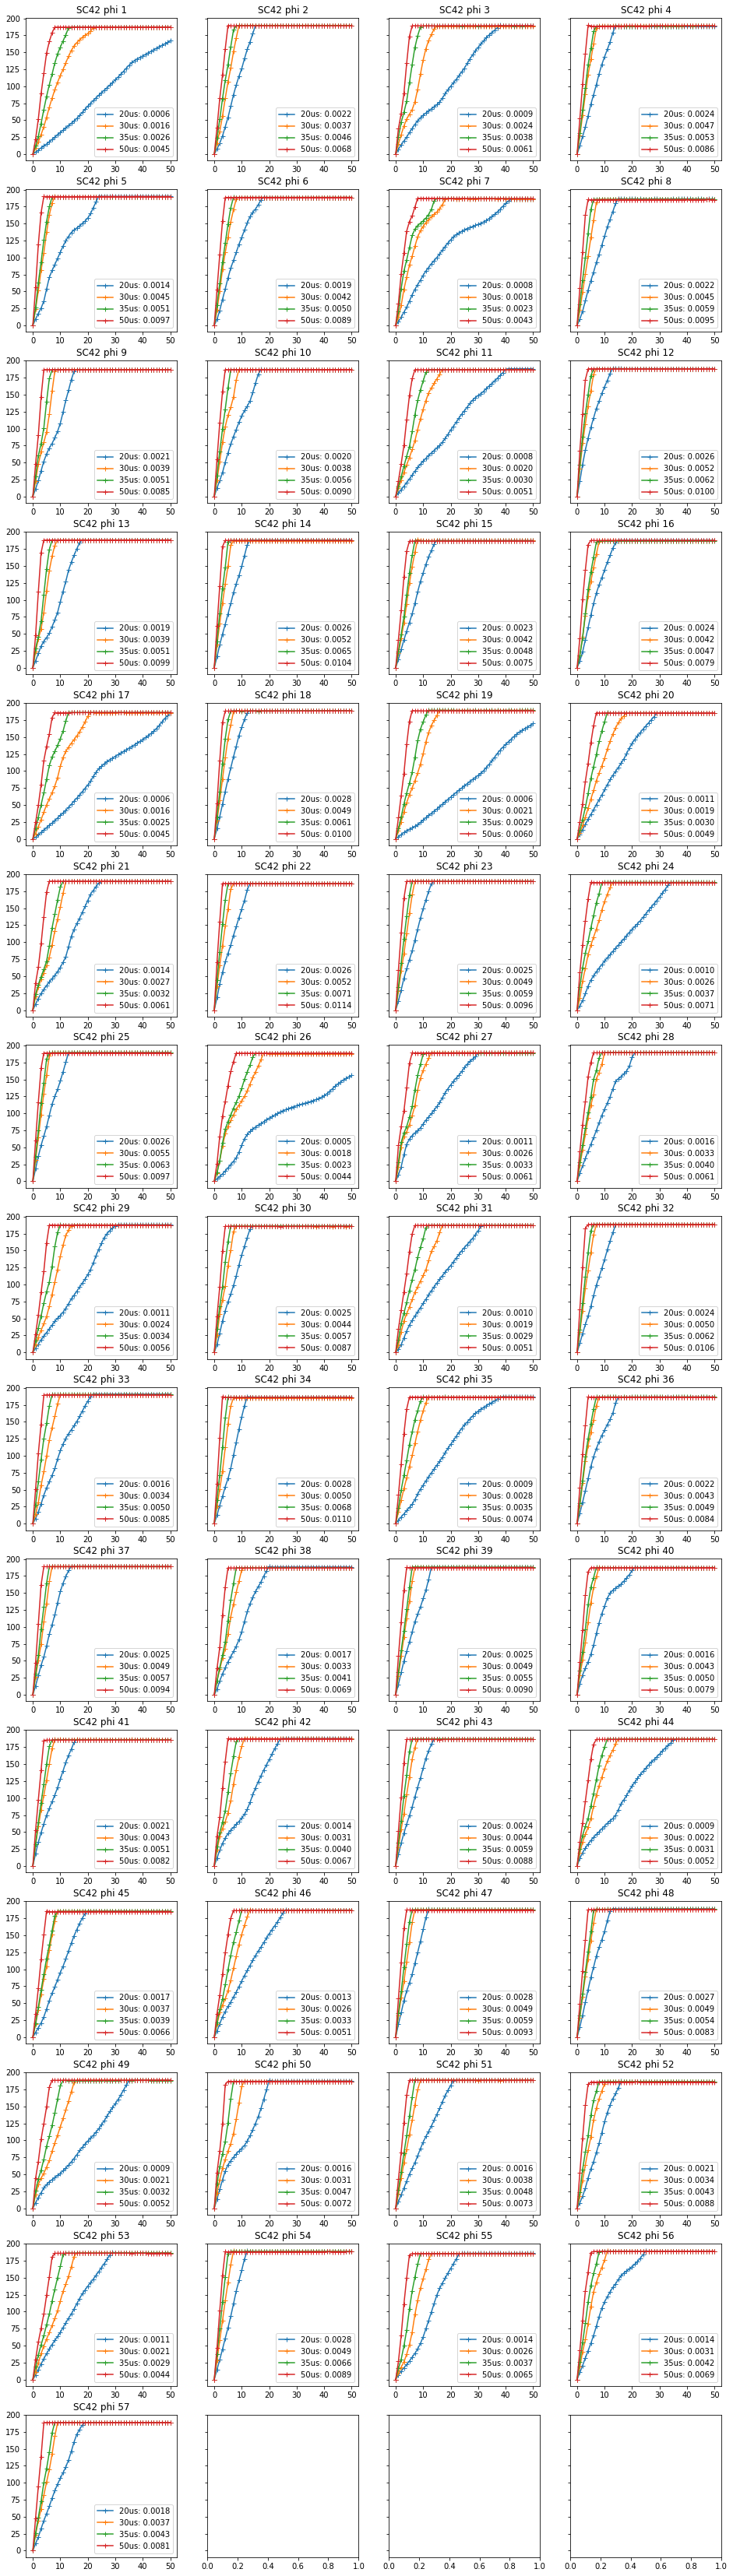

In [21]:
_ = plotUtils.plotOntimeSet(moduleName, phiRuns, 'phi', 100)

# CPL: need thumbs-up, thumbs-down on the final map.

Until we get a _decent_ phi ontime choice, we need this.

## 5 - Run phi convergence test.

At this point we know the phi motor center position, and we have a decent map. So run the phi convergence test now.
Note that we are applying Erin's heuristic, and dynamically scaling each motor's ontime with each move.

We are only trying for 10 mrad, or ~25 um. Off by a factor of 5.
Also, stay ~5 degrees away from ends, 

In [ ]:
rstate = np.random.RandomState(2394)
angles = rstate.uniform(5,175,100)

# Force us to finish at 60, just for convenience.
angles[-1] = 60.0
tolerance = np.rad2deg(0.01)

mt.setPhiCentersFromRun(phiGeometryRun)
for a_i, a in enumerate(angles):
    ret = mt.moveToPhiAngle(angle=a, tolerance=tolerance, 
                            keepExisting=(a_i > 0), maxTries=8)

## Make theta maps at several ontimes; create theta motor map

Takes a set of theta motor maps at a range of ontimes, then generates a new map with tuned slow and fast maps.

The initial map is named "SC42_thetaOntime.xml" or "SC42.xml", and the output is "SC42_theta.xml"

In [142]:
reload(moduleTest)
mt = moduleTest.ModuleTest('fpga', butler.mapPathForModule(moduleName, version='phiOntime'))

In [ ]:
thetaRuns = dict()

steps = 200
for thetaOntime in 80,65,50:
    outputDir = mt.makeThetaMotorMap(f'theta_{thetaOntime}ms.xml', thetaOnTime=thetaOntime/1000, 
                                     phiRunDir=phiGeometryRun, totalSteps=8000,
                                     updateGeometry=True, repeat=1, fast=False, steps=steps)
    thetaRuns[thetaOntime] = outputDir

2019-09-13 08:42:33.346Z butler           30 butler.py:54 newRun: \data\MCS\20190913_063
2019-09-13 08:42:33.478Z fpgaIO           20 pfi.py:56 FPGA connection to 128.149.77.24
2019-09-13 08:42:33.520Z pfi              20 pfi.py:72 load cobra model from c:\users\cobra\documents\pfssoft\devel\pfs_instdata\data\pfi\modules\SC42\SC42_phiOntime.xml
2019-09-13 08:42:33.569Z camera           20 citCam.py:13 cit...
2019-09-13 08:42:33.610Z moduleTest       20 moduleTest.py:930 theta home -8000 steps


[Initialize]: DRV_SUCCESS


2019-09-13 08:43:05.298Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 200
2019-09-13 08:43:12.773Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 400
2019-09-13 08:43:20.231Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 600
2019-09-13 08:43:28.268Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 800
2019-09-13 08:43:35.836Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 1000
2019-09-13 08:43:43.490Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 1200
2019-09-13 08:43:50.968Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 1400
2019-09-13 08:43:58.547Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 1600
2019-09-13 08:44:06.106Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 1800
2019-09-13 08:44:13.653Z moduleTest       20 moduleTest.py:941 1/1 theta forward to 2000
2019-09-13 08:44:21.223Z moduleTest       20 moduleTest.py:949 done: [ 3 34], 55 left
2019-09-13 08:44:21.224Z mod

In [ ]:
reload(plotUtils)
_ = plotUtils.plotOntimeSet(moduleName, runDirs, 'phi', steps)

In [ ]:
optmap.solveForSlowSpeed()
optmap.solveForFastSpeed()
optmap.saveOptMap(butler.mapPathForModule(moduleName, 'thetaOntime'))

## Test "optimal" theta map.

In [ ]:
mt = moduleTest.ModuleTest('fpga', butler.mapPathForModule(moduleName, version='thetaOntime'))
thetaGeometryRun = mt.makeThetaMotorMap(f'thetacheck.xml', repeat=1, fast=False, steps=100)

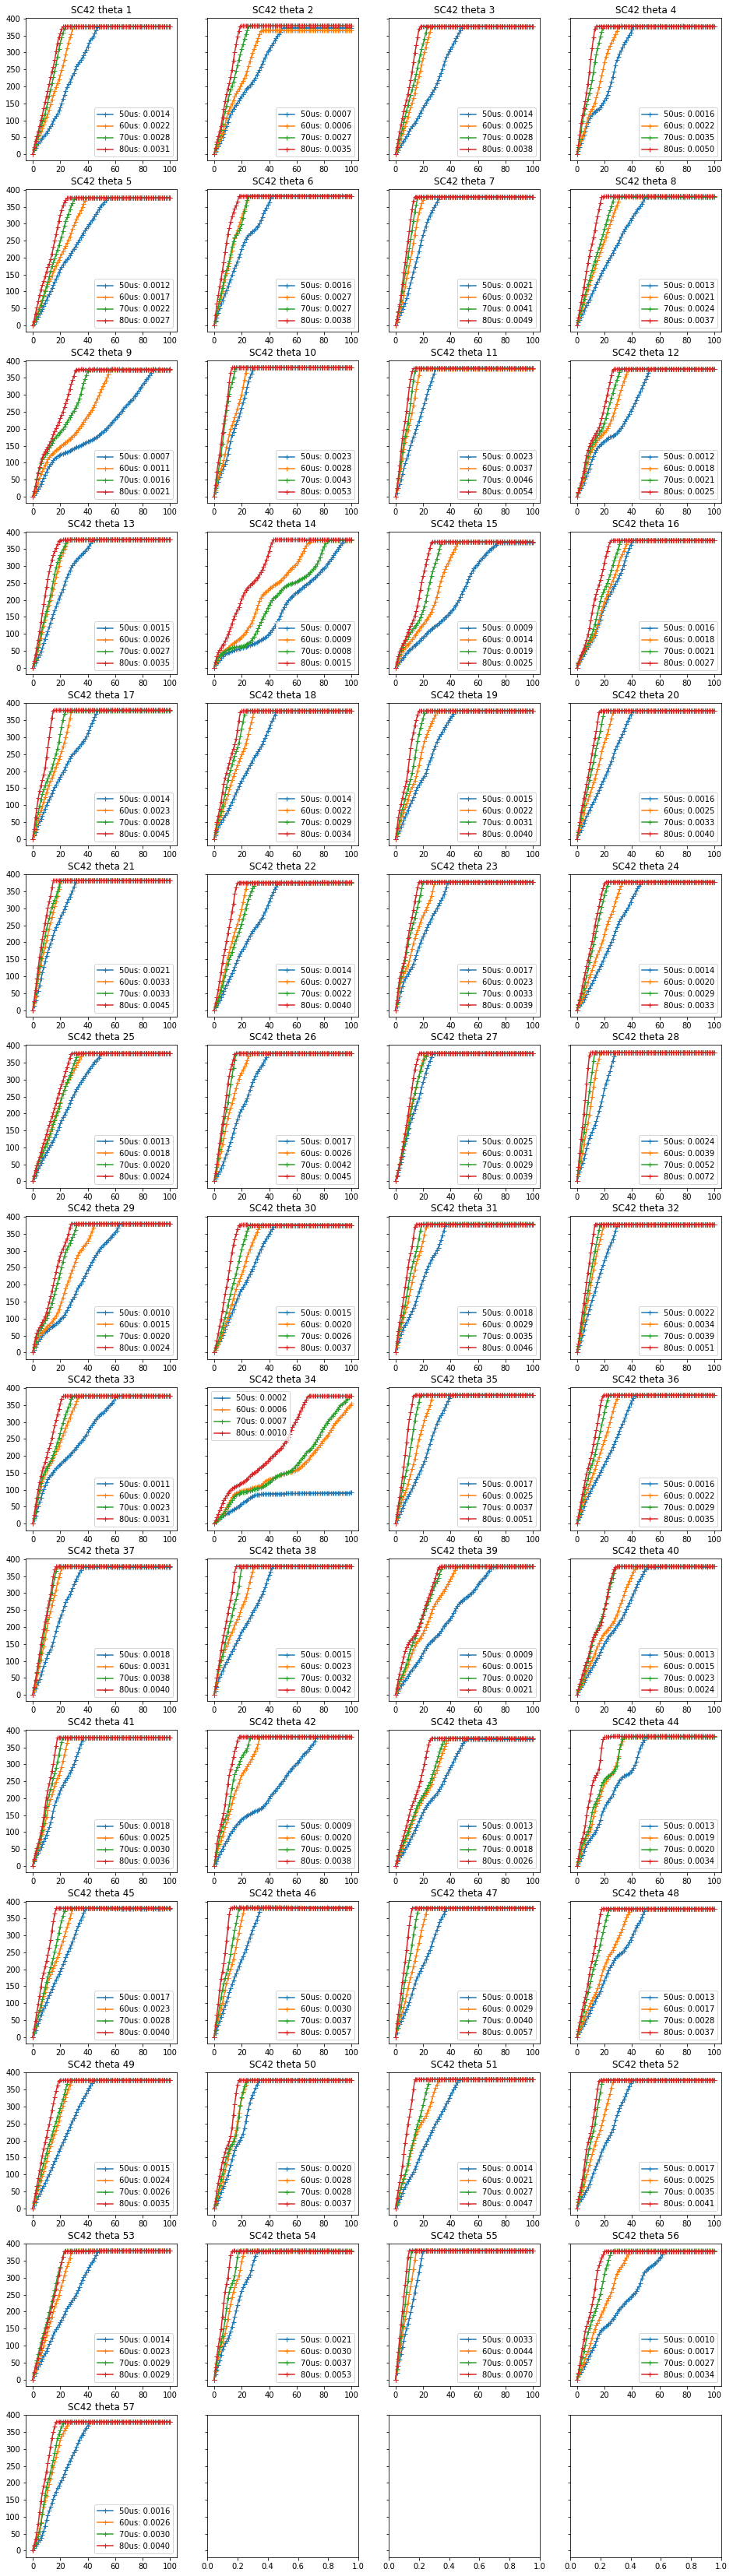

In [25]:
_ = plotUtils.plotOntimeSet(moduleName, thetaRuns, 'theta', 100)

In [39]:
reload(moduleTest)
mt = moduleTest.ModuleTest('fpga', butler.mapPathForModule(moduleName, version='thetaOntime'))
mt._connect()
mt.setThetaCentersFromRun(thetaGeometryRun)
# mt.pfi.resetMotorScaling()
mt.logger.setLevel(5)

2019-09-13 05:24:25.927Z butler           30 butler.py:54 newRun: \data\MCS\20190913_044
2019-09-13 05:24:25.953Z fpgaIO           20 pfi.py:56 FPGA connection to 128.149.77.24
2019-09-13 05:24:25.997Z pfi              20 pfi.py:72 load cobra model from c:\users\cobra\documents\pfssoft\devel\pfs_instdata\data\pfi\modules\SC42\SC42_thetaOntime.xml
2019-09-13 05:24:26.047Z camera           20 citCam.py:13 cit...


In [41]:
mt.logger.setLevel(20)
mod1 = mt.pfi.allocateCobraModule()
mt.pfi.moveAllSteps(mod1, -4000, 0)

In [17]:
%pdb on
ret = mt.moveToThetaAngle(angle=190, tolerance=np.rad2deg(0.005), keepExistingPosition=True, maxTries=8)
%pdb off

2019-09-13 04:02:55.897Z butler           30 butler.py:54 newRun: \data\MCS\20190913_031
2019-09-13 04:02:55.945Z fpgaIO           20 pfi.py:56 FPGA connection to 128.149.77.24
2019-09-13 04:02:55.990Z pfi              20 pfi.py:72 load cobra model from c:\users\cobra\documents\pfssoft\devel\pfs_instdata\data\pfi\modules\SC42\SC42_thetaOntime.xml
2019-09-13 04:02:56.040Z camera           20 citCam.py:13 cit...


Automatic pdb calling has been turned ON
[Initialize]: DRV_SUCCESS


2019-09-13 04:03:08.392Z moduleTest       10 moduleTest.py:143 saving 57 moves to \data\MCS\20190913_031\output\moves.npz
2019-09-13 04:03:08.399Z moduleTest       10 moduleTest.py:488 to: [190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190.
 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190.
 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190.
 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190.
 190.]
2019-09-13 04:03:08.400Z moduleTest       10 moduleTest.py:489 at: [100.13  99.98  99.88 100.03 100.07 100.   100.22  99.9  100.07 100.02
  99.96 100.12  99.91  99.92  99.92  99.99 100.09 100.   100.14 100.06
 100.05 100.17 100.04  99.98 100.11 100.06 100.11 100.18 100.07 100.03
 100.13 100.17 100.01  98.46 100.09  99.87 100.1  100.05  99.99 100.12
 100.12 100.01 100.02 100.13 100.05 100.09 100.22  99.96 100.13 100.11
 100.06 100.13  99.97  99.91 100.05 100.15 100.13]
2019-09-13 04:03:08.401Z moduleTest       20 mo

Automatic pdb calling has been turned OFF


In [ ]:
rstate = np.random.RandomState(2394)
angles = rstate.uniform(30,300,10)
testRuns = []
for a_i, a in enumerate(angles):
    ret = mt.moveToThetaAngle(angle=a, tolerance=np.rad2deg(0.005), 
                              keepExistingPosition=(a_i > 0), maxTries=8, scaleFactor=10)
    testRuns.append(ret)

In [26]:
root = pathlib.Path('/data/MCS')
pl = sorted(root.glob('**/thetaConvergence.npy'))
list(pl)

[WindowsPath('/data/MCS/20190913_003/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_004/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_006/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_007/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_008/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_009/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_010/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_025/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_026/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_027/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_028/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_029/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_030/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_031/output/thetaconvergence.npy'),
 WindowsPath('/data/MCS/20190913_034/output/thet

[WindowsPath('/data/MCS/20190913_003'), WindowsPath('/data/MCS/20190913_004'), WindowsPath('/data/MCS/20190913_006'), WindowsPath('/data/MCS/20190913_007'), WindowsPath('/data/MCS/20190913_008'), WindowsPath('/data/MCS/20190913_009'), WindowsPath('/data/MCS/20190913_010'), WindowsPath('/data/MCS/20190913_025'), WindowsPath('/data/MCS/20190913_026'), WindowsPath('/data/MCS/20190913_027'), WindowsPath('/data/MCS/20190913_028'), WindowsPath('/data/MCS/20190913_029'), WindowsPath('/data/MCS/20190913_030'), WindowsPath('/data/MCS/20190913_031'), WindowsPath('/data/MCS/20190913_034'), WindowsPath('/data/MCS/20190913_035'), WindowsPath('/data/MCS/20190913_036'), WindowsPath('/data/MCS/20190913_037'), WindowsPath('/data/MCS/20190913_038'), WindowsPath('/data/MCS/20190913_039'), WindowsPath('/data/MCS/20190913_040'), WindowsPath('/data/MCS/20190913_041'), WindowsPath('/data/MCS/20190913_042'), WindowsPath('/data/MCS/20190913_043')]
Automatic pdb calling has been turned ON


2019-09-13 05:05:22.458Z matplotlib.font_manager 10 font_manager.py:1259 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2019-09-13 05:05:22.459Z matplotlib.font_manager 10 font_manager.py:1271 findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
2019-09-13 05:05:22.460Z matplotlib.font_manager 10 font_manager.py:1271 findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
2019-09-13 05:05:22.461Z matplotlib.font_manager 10 font_manager.py:1271 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2019-09-13 05:05:22.461Z matplotlib.font_manager 10 font_manager.py:1271 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
2019-09-13 05:05:22.462Z matplotlib.font_manager 10 font_manager.py:1271 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) n

Automatic pdb calling has been turned OFF


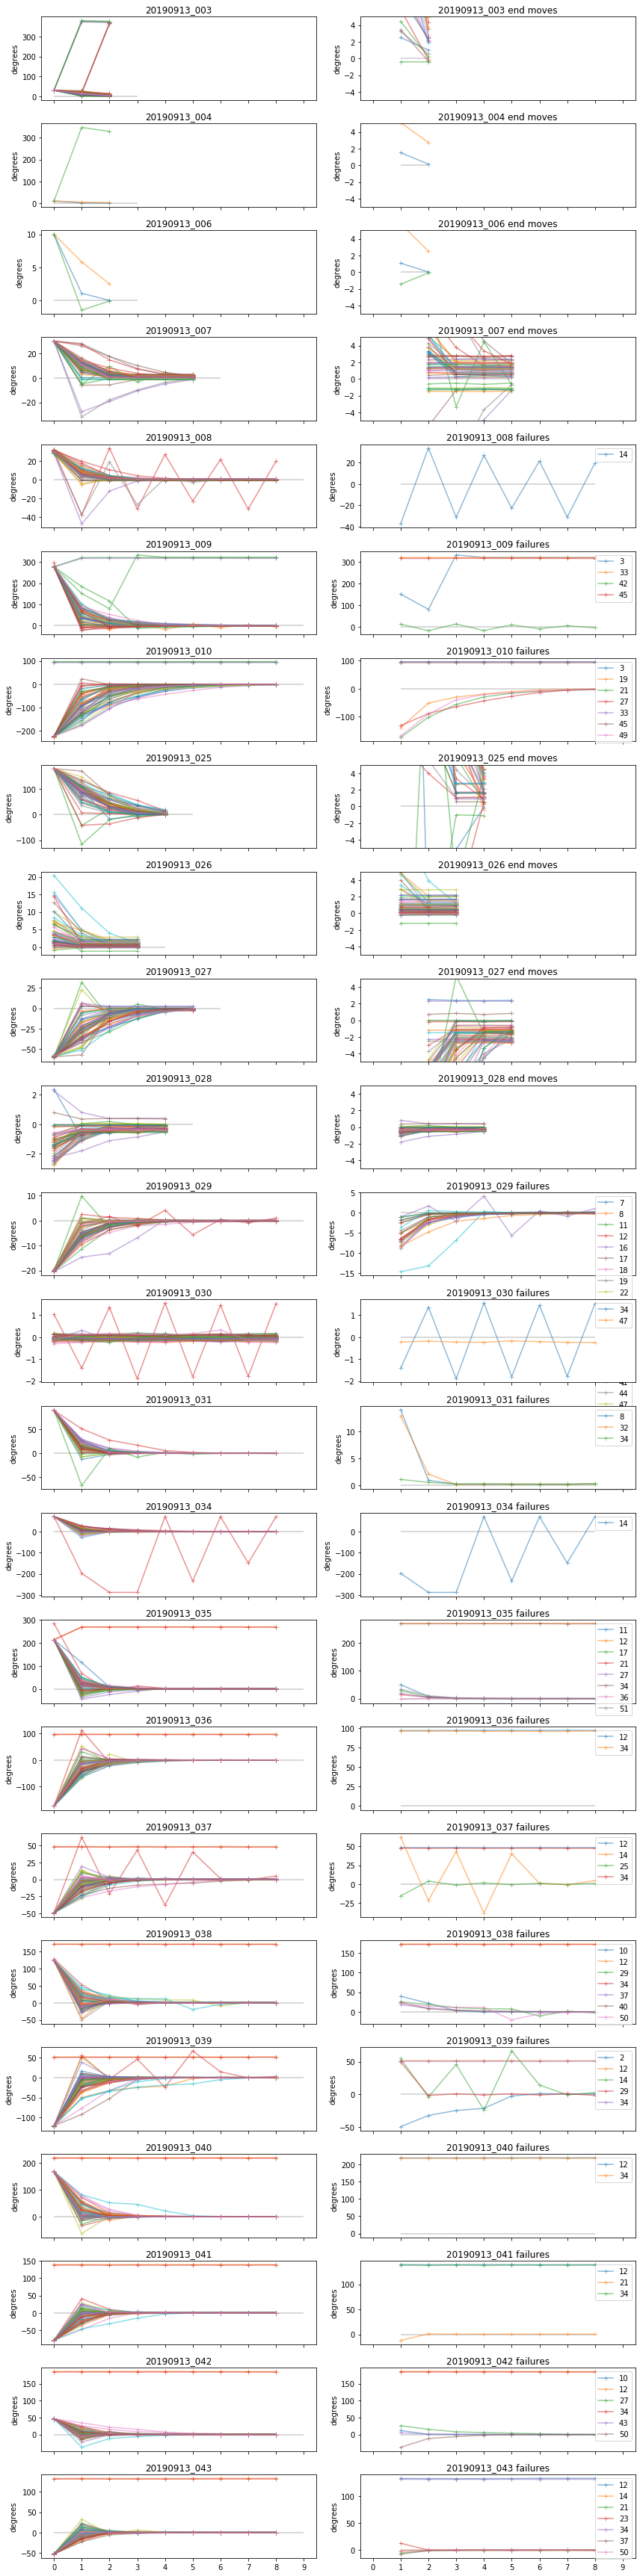

In [36]:
thetaRuns = sorted([p.parent.parent for p in pl])
print(thetaRuns)
reload(plotUtils)
%pdb on
plotUtils.plotConvergenceRuns(thetaRuns, 'theta')
%pdb off
